<div class='heading'>
    <div style='float:left;'><h1>Project: ChatGPT Some Trained Models 3.5 and 4</h1>
        <h3>ipynb file: Email Phish Annotation with some training.ipynb</h3>
        <h4>**Clemson University**<br>
            <BR>
            MUST RENAME FILE LOCATIONS TO WHERE THE DATA EXISTS
        <h5>To use this notebook, .env file must be in the directory you start juypter lab</h5>
        <h5>Make sure you install dependencies
                pip install openai python-dotenv</h5></div>
    <img style="float: right; padding-right: 10px; width: 65px" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>
    



---

In [1]:
""" RUN THIS CELL TO GET THE RIGHT FORMATTING """
import requests
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/css/cpsc6300.css'
styles = requests.get(css_file).text
HTML(styles)

In [2]:
from dotenv import load_dotenv
import os
from openai import OpenAI
import pandas as pd
import numpy as np
import time
import glob
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load up the API Keys for GPT

load_dotenv()

my_id = os.getenv("OPENAI_API_KEY")

client = OpenAI(
    api_key=os.environ.get("my_id"),
)

In [9]:
# Define a module to do the GPT call this way we don't have to call it everytime we want to test something
def Annotate_data(df):

    #initialize varibles for this module
    
    results = []
    temp = []
    out_prompt = []
    in_prompt = df['Prompt']

    #default the temp for the OpenAI call
    temperature_value = 0.25

    prompt = f"""Given an email, analyze the following email and classify as phishing or legitimate with reasons "Provide the classification and reasoning:\n{in_prompt}\n"""

    retries = 1
    while retries > 0:
        try:
            start = time.time()

            response = client.chat.completions.create(
                model='gpt-4',
                #model='gpt-3.5-turbo',
                temperature=temperature_value,
                messages=[
                    {"role": "system", "content": "You are a skilled security expert"},
                    {"role": "user", "content": prompt}
                      ],
                max_tokens=30,
            )

            print ("-----\n")    
            print (response)
                
            results.append(response.choices[0].message.content.strip())
            temp.append(temperature_value)
            out_prompt.append(in_prompt)

            break  # Exit the retry loop if the request is successful

        except Exception as e:
            
            print(f"Error: {e}")
            
            # we add delay to avoid having the model overloaded
            retries -= 1
            time.sleep(10)  # Wait for 10 seconds before retrying

    # Add the results as a new column to the DataFrame
    df1 = pd.DataFrame()
    
    df1['Prompt'] = out_prompt
    df1['BaseLine-Category'] = df['BaseLine-Category']
    df1['Legit'] = results
    df1['Phish'] = 0
    df1['Unknown'] = 0
    df1['Temp'] = temp
    df1['ElapsedTime'] = round(time.time() - start, 3)

    return (df1)

In [13]:
#Build the list of files to read into a single DF

prompt_files = sorted(glob.glob('/Users/roulierk/Documents/Clemson/Thesis/Seven-Phishing-email-data/test_email_prompt*.csv'))

prompt_df = pd.DataFrame()
                             
for file in prompt_files:
    r_df = pd.read_csv(file, 
        sep=',',
        error_bad_lines=False,
        header=None)

    r_df.columns=(['subject', 'body', 'BaseLine-Category', 'Legit', 'Phish', 'Unknown', 'Temp', 'ElapsedTime'])    
        
    r_df['Prompt'] = 'Subject: ' + r_df['subject'] + 'Body: ' + r_df['body']

    r_df.drop(['subject', 'body'], axis=1, inplace=True)
    
    prompt_df = pd.concat([prompt_df, r_df], ignore_index=True)
    
    display (prompt_df)

,BaseLine-Category,Legit,Phish,Unknown,Temp,ElapsedTime,Prompt
0,0.0,NaN,NaN,NaN,0,0,Subject: re : midcon transport usage tickets -...
1,1.0,NaN,NaN,NaN,0,0,Subject: online approval for $ 5000 nowBody: s...
2,1.0,NaN,NaN,NaN,0,0,Subject: femmerol - clinically proven to fight...
3,0.0,NaN,NaN,NaN,0,0,"Subject: hpl nom for november 10 , 2000Body: (..."
4,1.0,NaN,NaN,NaN,0,0,Subject: here you goBody: enough door eat know...
5,0.0,NaN,NaN,NaN,0,0,Subject: re : ebs positionBody: june 16 full -...
6,1.0,NaN,NaN,NaN,0,0,Subject: from bar . stephen kwesiBody: barrist...
7,0.0,NaN,NaN,NaN,0,0,"Subject: ena trading trackBody: all ,\nthank y..."
8,0.0,NaN,NaN,NaN,0,0,Subject: re : global operations controller for...
9,0.0,NaN,NaN,NaN,0,0,Subject: start date : 1 / 15 / 02 ; hourahead ...


# ==== Only need to run the next block if you want to call GPT ========

In [19]:
#Call GPT engine to build the working DFs

chat_df = pd.DataFrame()
result_df = pd.DataFrame()
    
for ind in prompt_df.index:
    chat_df = Annotate_data(prompt_df.iloc[ind])
    
    print ("=================\n")
    #print (chat_df.Legit)

    if (chat_df.Legit.str.contains('Legit').bool()) | (chat_df.Legit.str.contains('legit').bool()): 
            chat_df.Legit = 1
    elif (chat_df.Legit.str.contains('Phish').bool()) | (chat_df.Legit.str.contains('phish').bool()): 
            chat_df.Phish = 1
    else : 
            chat_df.Unknown = 1
            
    chat_df.loc[chat_df['Legit'] != 1, "Legit"] = 0
    chat_df.loc[chat_df['Unknown'] != 1, "Unknown"] = 0
    chat_df.loc[chat_df['Phish'] != 1, "Phish"] = 0
    
    chat_df["Legit"] = chat_df["Legit"].astype(float)    
    chat_df["Phish"] = chat_df["Phish"].astype(float)    
    chat_df["Unknown"] = chat_df["Unknown"].astype(float)
    print (chat_df.Legit, "\n")
    print (chat_df.Phish, "\n")
    print (chat_df.Unknown, "\n")
        
    result_df = result_df.append(chat_df, ignore_index = True)

-----

ChatCompletion(id='chatcmpl-AJka3qTvOQG7jEwfkN8TN3Pvr3z9e', choices=[Choice(finish_reason='length', index=0, logprobs=None, message=ChatCompletionMessage(content='Classification: Legitimate\n\nReasoning: The email appears to be a legitimate business correspondence between two individuals discussing work-related matters. The email contains specific details', role='assistant', function_call=None, tool_calls=None, refusal=None))], created=1729270651, model='gpt-4-0613', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=30, prompt_tokens=272, total_tokens=302, prompt_tokens_details={'cached_tokens': 0}, completion_tokens_details={'reasoning_tokens': 0}))

0    1.0
Name: Legit, dtype: float64 

0    0.0
Name: Phish, dtype: float64 

0    0.0
Name: Unknown, dtype: float64 

-----

ChatCompletion(id='chatcmpl-AJka4kj35wyLIt1CFhB6lr571FD5w', choices=[Choice(finish_reason='length', index=0, logprobs=None, message=ChatCompletionMessage(content="Cla

# Code from here on is to visualize results

In [20]:
result_df.info()
display (result_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Prompt             10 non-null     object 
 1   BaseLine-Category  10 non-null     float64
 2   Legit              10 non-null     float64
 3   Phish              10 non-null     float64
 4   Unknown            10 non-null     float64
 5   Temp               10 non-null     float64
 6   ElapsedTime        10 non-null     float64
dtypes: float64(6), object(1)
memory usage: 688.0+ bytes


,Prompt,BaseLine-Category,Legit,Phish,Unknown,Temp,ElapsedTime
0,Subject: re : midcon transport usage tickets -...,0.0,1.0,0.0,0.0,0.25,1.500
1,Subject: online approval for $ 5000 nowBody: s...,1.0,0.0,1.0,0.0,0.25,1.533
2,Subject: femmerol - clinically proven to fight...,1.0,1.0,0.0,0.0,0.25,1.806
3,"Subject: hpl nom for november 10 , 2000Body: (...",0.0,1.0,0.0,0.0,0.25,1.501
4,Subject: here you goBody: enough door eat know...,1.0,1.0,0.0,0.0,0.25,1.616
5,Subject: re : ebs positionBody: june 16 full -...,0.0,1.0,0.0,0.0,0.25,1.528
6,Subject: from bar . stephen kwesiBody: barrist...,1.0,0.0,1.0,0.0,0.25,2.030
7,"Subject: ena trading trackBody: all ,\nthank y...",0.0,1.0,0.0,0.0,0.25,1.374
8,Subject: re : global operations controller for...,0.0,1.0,0.0,0.0,0.25,1.672
9,Subject: start date : 1 / 15 / 02 ; hourahead ...,0.0,1.0,0.0,0.0,0.25,1.343


In [24]:
printdf = result_df.cumsum()
display (printdf)

#ignore the "Prompt" column in this summary table.  It will always be the first entry since it can't be summed.

,Prompt,BaseLine-Category,Legit,Phish,Unknown,Temp,ElapsedTime
0,Subject: re : midcon transport usage tickets -...,0.0,1.0,0.0,0.0,0.25,1.500
1,Subject: re : midcon transport usage tickets -...,1.0,1.0,1.0,0.0,0.50,3.033
2,Subject: re : midcon transport usage tickets -...,2.0,2.0,1.0,0.0,0.75,4.839
3,Subject: re : midcon transport usage tickets -...,2.0,3.0,1.0,0.0,1.00,6.340
4,Subject: re : midcon transport usage tickets -...,3.0,4.0,1.0,0.0,1.25,7.956
5,Subject: re : midcon transport usage tickets -...,3.0,5.0,1.0,0.0,1.50,9.484
6,Subject: re : midcon transport usage tickets -...,4.0,5.0,2.0,0.0,1.75,11.514
7,Subject: re : midcon transport usage tickets -...,4.0,6.0,2.0,0.0,2.00,12.888
8,Subject: re : midcon transport usage tickets -...,4.0,7.0,2.0,0.0,2.25,14.560
9,Subject: re : midcon transport usage tickets -...,4.0,8.0,2.0,0.0,2.50,15.903


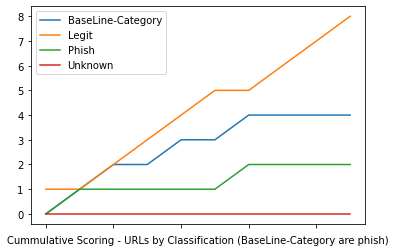

In [17]:
printdf.plot(x="Prompt", y=["BaseLine-Category", "Legit", "Phish", "Unknown"], xlabel="URLs")
plt.gca().set_xticklabels([])
plt.xlabel("Cummulative Scoring - URLs by Classification (BaseLine-Category are phish)")
plt.show()

In [18]:
printdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Prompt             10 non-null     object 
 1   BaseLine-Category  10 non-null     float64
 2   Legit              10 non-null     float64
 3   Phish              10 non-null     float64
 4   Unknown            10 non-null     float64
 5   Temp               10 non-null     float64
 6   ElapsedTime        10 non-null     float64
dtypes: float64(6), object(1)
memory usage: 688.0+ bytes
